In [1]:
#Gene expression Matrix provided in NCBI GEO was too large so we separated the file into chunks
# and stripped for TyROBP and FCER1G expressions in the chunks
# Values given as natural log TPM values : log2(x) = ln(x)*log2(e) = ln(x)*1.4427: We apply this scaling factor below

# In total, 7102 of 63689 are macrophages

In [16]:
# IMPORT STATEMENTS
from statsmodels.stats.proportion import proportions_ztest
import cv2
import re
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import matplotlib.patches as patches
import matplotlib.colors as colors
import PIL
import math
%matplotlib inline
import pandas as pd
import seaborn as sns
import json
from scipy.stats import fisher_exact, ttest_ind
from collections import Counter
from pprint import pprint
import os
import pickle
import sys
from anndata import AnnData
import scanpy as sc
sys.path.append("/booleanfs2/sahoo/Hegemon/")
sys.path = ["/booleanfs2/sahoo/BoNE/"] + sys.path
import StepMiner as smn
import HegemonUtil as hu
acolor = ["#00CC00", "#D8A03D","#EC008C",
          'cyan', "#B741DC", "#808285",
          'blue', 'black', 'green', 'red',
          'orange', 'brown', 'pink', 'purple']

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

import bone
reload(bone)

sys.path.append("/booleanfs2/sahoo/Hegemon/")
sys.path = ["/booleanfs2/sahoo/BoNE/"] + sys.path

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3
        
import SMaRT.MacUtils as mut
reload(mut)

<module 'SMaRT.MacUtils' from '/booleanfs2/sahoo/BoNE/SMaRT/MacUtils.py'>

In [3]:
def getSViP():
    l1 = [bone.readList("covid/iav-list-1.txt")[0:20]] # 20 gene signature
    wt1 = [1]
    return wt1, l1

def getViP():
    l1 = [bone.readList("covid/list-2.txt")] # 166 gene signature
    wt1 = [1]
    return wt1, l1

def getSimpleName(gene_groups, h):
    res = []
    for s in gene_groups:
        s1 = set()
        for g in s:
            for id1 in h.getIDs(g):
                name = h.getSimpleName(id1)
                if name != "" and name != "---":
                    s1.add(name)
        res.append(s1)
    return res

def getMacGeneGroups(order = None, weight = None, debug = 1):
    reload(hu)
    db = hu.Database("/booleanfs2/sahoo/Hegemon/explore.conf")
    h = hu.Hegemon(db.getDataset("GL4"))
    h.init()
    h.initPlatform()
    h.initSurv()
    data_item = []
    dir1 = "/booleanfs2/sahoo/Data/Macrophage/BN/"
    with open(dir1 + 'figures/path-1.json') as data_file:
        data_item += json.load(data_file)
    with open(dir1 + 'figures/path-0.json') as data_file:
        l1 = json.load(data_file)
        data_item[5] = l1[5]
        data_item[6] = l1[6]
    with open(dir1 + 'figures/path-2.json') as data_file:
        data_item += json.load(data_file)
    with open(dir1 + 'figures/path-3.json') as data_file:
        data_item += json.load(data_file)
    with open(dir1 + 'figures/path-4.json') as data_file:
        data_item += json.load(data_file)
    cfile = dir1 + "figures/mac-net-cls.txt"
    if not os.path.isfile(cfile):
        print ("Can't open file {0} <br>".format(cfile))
        exit()
    fp = open(cfile, "r")
    nodelist = {}
    nhash = {}
    for line in fp:
        line = line.strip();
        ll = line.split("\t");
        nodelist[ll[0]] = ll[2:]
        for i in ll[2:]:
            nhash[i] = ll[0];
    fp.close();
    gene_groups = []
    for i in range(len(data_item)):
        gene_groups.append(set())
        gn = data_item[i][2][0][0]
        for g in data_item[i][2]:
            gene_groups[i].add(g[0])
            if g[0] in nodelist:
                for k in nodelist[g[0]]:
                    gene_groups[i].add(k)
        for g in data_item[i][3]:
            gene_groups[i].add(g)
            if g in nodelist:
                for k in nodelist[g]:
                    gene_groups[i].add(k)
        if debug == 1:
            print (i, gn, h.getSimpleName(gn), data_item[i][0], len(gene_groups[i]))
    print([len(s) for s in gene_groups])
    if order is None:
        order = [1, 3, 4, 5];
        order = [35]
        order = [43, 44, 45];
        order = [8, 9, 10]
    gene_groups = [gene_groups[i] for i in order]
    print([len(s) for s in gene_groups])
    gene_groups = getSimpleName(gene_groups, h)
    print([len(s) for s in gene_groups])
    if weight is None:
        weight = [-1, 1, 2, 3]
        weight = [-1, -2, -3]
        weight = [-1]
        weight = [-1, -2, -3]
    print (weight)
    genes = bone.readGenes(dir1 + "figures/cluster-names.txt")
    return genes, weight, gene_groups

def getCls13a14a3():
    order = [13, 14, 3]
    wt1 = [-1, 1, 2]
    nx = [0, 1, 4, 5, 6, 8, 9, 10, 16, 17, 19, 20, 21, 25, 28]
    genes, wt1, l1 = getMacGeneGroups([nx[i] for i in order], wt1, 0)
    return wt1, l1

def getCls13():
    order = [13]
    wt1 = [-1]
    nx = [0, 1, 4, 5, 6, 8, 9, 10, 16, 17, 19, 20, 21, 25, 28]
    genes, wt1, l1 = getMacGeneGroups([nx[i] for i in order], wt1, 0)
    return wt1, l1

def getCls14a3():
    order = [14, 3]
    wt1 = [1, 2]
    nx = [0, 1, 4, 5, 6, 8, 9, 10, 16, 17, 19, 20, 21, 25, 28]
    genes, wt1, l1 = getMacGeneGroups([nx[i] for i in order], wt1, 0)
    return wt1, l1

def processOne(ana, order, wt1, ax1, ax2, id1 = None, l1=None, violin=1):
    genes = []
    if (l1 is None):
        nx = [0, 1, 4, 5, 6, 8, 9, 10, 16, 17, 19, 20, 21, 25, 28]
        sel = 2
        genes, wt1, l1 = getMacGeneGroups([nx[i] for i in order], wt1, 0)
    ana.orderData(l1, wt1)
    if id1 is None:
        params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1
,
                'genes': genes, 'ax': ax1, 'acolor': acolor}
        ax = ana.printTitleBar(params)
        res = ana.getROCAUC()
        ax.text(len(ana.cval[0]), 4, res)
        if (violin == 1):
            params['ax'] = ax2
            params['vert'] = 0
            ax = ana.printViolin(None, params)
        else:
            ax = ana.densityPlot(ax2, acolor)
        return ana
    else:
        params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1
,
                'genes': genes, 'acolor': acolor}
        ax = ana.printTitleBar(params)
        if (violin == 1):
            ax = ana.printViolin(None, {'vert':0})
        else:
            ax = ana.densityPlot()
    expr = ana.h.getExprData(id1)
    c = [acolor[ana.aval[i]] for i in ana.order]
    a = [ana.aval[i] for i in ana.order]
    x = [float(expr[i]) for i in ana.order]
    y = [ana.f_ranks[i - ana.h.start] for i in ana.order]
    df = pd.DataFrame()
    df['x'] = x
    df['y'] = y
    df['c'] = c
    df['a'] = a
    ax = df.plot('x', 'y', c=c, kind = 'scatter')
    ana.addAxes(ax)
    for i in range(len(ana.atypes)):
        cond1 = (df['a'] == i)
        if (sum(cond1) > 0):
            s1 = np.max(df[cond1]['y']) - np.min(df[cond1]['y'])
            s2 = np.max(df[cond1]['x']) - np.min(df[cond1]['x'])
            df.loc[cond1, 'y'] += (np.mean(df[cond1]['x']) - df.loc[cond1, 'x']) * (s1+1) / (s2+1)
            df.loc[cond1, 'x'] -= (np.mean(df[cond1]['y']) - df.loc[cond1, 'y']) * (s2+1) / (s1+1)
    ax = df.plot('x', 'y', c=c, kind = 'scatter')
    ana.addAxes(ax)
    from sklearn.linear_model import LinearRegression
    linreg = LinearRegression(normalize=True)
    linreg.fit(np.array(df['x']).reshape(-1, 1),df['y'])
    y_pred = linreg.predict(np.array(df['x']).reshape(-1, 1))
    df['y1'] = (df['y'] - y_pred)
    ax = df.plot('x', 'y1', c=c, kind = 'scatter')
    ana.addAxes(ax)
    ana.f_ranks = df['y1']
    ana.i1 = [ana.order[i] for i in np.argsort(ana.f_ranks)]
    ana.f_ranks = [0 for i in ana.h.aRange()]
    for i in range(len(ana.order)):
        ana.f_ranks[ana.order[i] - ana.h.start] = df['y1'][i]
    index = np.array([i - ana.h.start for i in ana.i1])
    ana.cval = np.array([[ana.aval[i] for i in ana.i1]])
    ana.data = np.array([ana.expr[i] for i in ana.ind_r])[:,index]

    params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1,
                  'genes': genes, 'ax': ax1, 'acolor': acolor}
    ax = ana.printTitleBar(params)
    if (violin == 1):
        params['ax'] = ax2
        params['vert'] = 0
        ax = ana.printViolin(None, params)
    else:
        ax = ana.densityPlot(ax2, acolor)

    return ana

def processDataHnorm(ana, id1 = None):
    fig = plt.figure(figsize=(15,4), dpi=100)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    ax1 = plt.subplot2grid((4, 3), (0, 0))
    ax2 = plt.subplot2grid((4, 3), (1, 0), rowspan=3)
    ax3 = plt.subplot2grid((4, 3), (0, 1))
    ax4 = plt.subplot2grid((4, 3), (1, 1), rowspan=3)
    ax5 = plt.subplot2grid((4, 3), (0, 2))
    ax6 = plt.subplot2grid((4, 3), (1, 2), rowspan=3)
    order = [13]
    wt1 = [-1]
    processOne(ana, order, wt1, ax1, ax2, id1)
    order = [14, 3]
    wt1 = [1, 2]
    processOne(ana, order, wt1, ax3, ax4, id1)
    order = [13, 14, 3]
    wt1 = [-1, 1, 2]
    processOne(ana, order, wt1, ax5, ax6, id1)
    return fig

def processDataHMm(ana, violin=1):
    nx = [0, 1, 4, 5, 6, 8, 9, 10, 16, 17, 19, 20, 21, 25, 28]
    sel = 2
    order = [13]
    wt1 = [-1]
    genes, wt1, l1 = getMacGeneGroups([nx[i] for i in order], wt1, 0)
    ana.convertMm(l1, genes)
    ana.orderData(ana.gene_groups, wt1)
    print(" ".join([str(ana.atype[i]) for i in ana.i1]))
    #ana.normMacrophageGene("TYROBP", {"thr":1})
    #ana.normMacrophageGene("FCER1G", {"thr":3, "tval":6.5, "select":sel})
    print(len(ana.col_labels), len(ana.row_ids))
    fig = plt.figure(figsize=(15,4), dpi=100)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    ax = plt.subplot2grid((4, 3), (0, 0))
    params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1,
              'genes': genes, 'ax': ax, 'acolor': acolor}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    ax.text(len(ana.cval[0]), 4, ",".join(res))
    ax = plt.subplot2grid((4, 3), (1, 0), rowspan=3)
    ax2 = plt.subplot2grid((4, 3), (0, 1))
    ax3 = plt.subplot2grid((4, 3), (1, 1), rowspan=3)
    if (violin == 1):
        params['ax'] = ax
        params['vert'] = 0
        ax = ana.printViolin(None, params)
        ax.set_ylabel("Violin - Cluster \\#13")
    else:
        ax = ana.densityPlot(ax, acolor)
        ax.set_ylabel("Density - Cluster \\#13")
    #plt.tight_layout()
    order = [14, 3]
    wt1 = [1, 2]
    genes, wt1, l1 = getMacGeneGroups([nx[i] for i in order], wt1, 0)
    ana.convertMm(l1, genes)
    ana.orderData(ana.gene_groups, wt1)
    print(" ".join([str(ana.atype[i]) for i in ana.i1]))
    #ana.normMacrophageGene("TYROBP", {"thr":1})
    #ana.normMacrophageGene("FCER1G", {"thr":3, "tval":6.5, "select":sel})
    print(len(ana.col_labels), len(ana.row_ids))
    params.update({'ax':ax2})
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    ax.text(len(ana.cval[0]), 4, ",".join(res))
    if (violin == 1):
        params['ax'] = ax3
        params['vert'] = 0
        ax = ana.printViolin(None, params)
        ax.set_ylabel("Violin - Cluster \\#14-3")
    else:
        ax = ana.densityPlot(ax3, acolor)
        ax.set_ylabel("Density - Cluster \\#14-3")
    ax2 = plt.subplot2grid((4, 3), (0, 2))
    ax3 = plt.subplot2grid((4, 3), (1, 2), rowspan=3)
    order = [13, 14, 3]
    wt1 = [-1, 1, 2]
    genes, wt1, l1 = getMacGeneGroups([nx[i] for i in order], wt1, 0)
    ana.convertMm(l1, genes)
    ana.orderData(ana.gene_groups, wt1)
    print(" ".join([str(ana.atype[i]) for i in ana.i1]))
    #ana.normMacrophageGene("TYROBP", {"thr":1})
    #ana.normMacrophageGene("FCER1G", {"thr":3, "tval":6.5, "select":sel})
    print(len(ana.col_labels), len(ana.row_ids))
    params.update({'ax':ax2})
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    ax.text(len(ana.cval[0]), 4, ",".join(res))
    if (violin == 1):
        params['ax'] = ax3
        params['vert'] = 0
        ax = ana.printViolin(None, params)
        ax.set_ylabel("Violin - Cluster \\#13-14-3")
    else:
        ax = ana.densityPlot(ax3, acolor)
        ax.set_ylabel("Density - Cluster \\#13-14-3")
    return fig

def getHigh(ana, tn=0, thr=2.0, nthr=10):
    order = [i for i in ana.order if ana.aval[i] == tn]
    fp = ana.h.fp;
    fp.seek(0, 0);
    h = fp.readline();
    res = []
    index = 0
    for line in fp:
        line = line.strip();
        ll = line.split("\t")
        l1 = [i for i in order if i < len(ll) and
              ll[i] != '' and float(ll[i]) > thr]
        if len(l1) > nthr:
            res.append([ll[0], ana.h.getSimpleName(ll[0]), len(l1)])
        index += 1
        if (index % 1000) == 0:
            print(index)
    return res

def getHighJava(ana, tn=0, thr=2.0, nthr=10):
    order = [i for i in ana.order if ana.aval[i] == tn]
    ofh = open(".arrorder", "w")
    for i in order:
        ofh.write(ana.headers[i] + "\n")
    ofh.close()
    from subprocess import check_output
    cmd = ['java', '-cp', '/booleanfs2/sahoo/Hegemon',
           'tools.Hegemon', 'high', ana.h.getPre(),
           '.arrorder', str(thr), str(nthr)]
    result = check_output(cmd, input='')
    l1 = result.decode('utf-8').split('\n')
    res = [k.split('\t') for k in l1 if k != '']
    res = [[k[0], ana.h.getSimpleName(k[0]), k[1]] for k in res]
    return res

def getCls14a3v2():
    l1 = [['RPS16', 'RPS21', 'RPL6', 'CCDC88A', 'RPL3', 'RPS15A', 'RPL14',
        'PCBP2', 'RPL23', 'RPL13', 'METTL7A'],
        ['CLEC10A', 'ANXA4', 'UBL3', 'RPS21', 'RPL6', 'RPS15A', 'ARL4C',
            'RPL14', 'HEXA', 'METTL7A', 'RPS16']]
    l1 = [['RPL24', 'NACA', 'RPS16', 'RPS21', 'RPL6', 'CCDC88A',
        'RPL3', 'RPS15A', 'EEF1B2', 'RPL14', 'PCBP2', 'RPL23',
        'RPL13', 'METTL7A', 'EEF2'],
        ['CLEC10A', 'INPP5A', 'NACA', 'ANXA4', 'UBL3', 'RPS21',
            'ITSN1', 'RPL24', 'RPS15A', 'ARL4C', 'RPL14', 'RPL6',
            'HEXA', 'METTL7A', 'EEF2', 'RPS16']]
    wt1 = [1, 2]
    return wt1, l1

bone.getCls13 = getCls13
bone.getCls14a3 = getCls14a3
bone.getCls13a14a3 = getCls13a14a3
bone.getCls14a3v2 = getCls14a3v2

def getIDhash(adata):
    idhash = {}
    for i in range(len(adata.raw.var['gene_symbols'])):
        k = adata.raw.var['gene_symbols'][i]
        v = adata.raw.var['gene_ids'][i]
        if k not in idhash:
            idhash[k] = []
        idhash[k] += [v]
    return idhash

def getRanks3(gene_groups, adata):
    idhash = getIDhash(adata)
    expr = []
    row_labels = []
    row_ids = []
    row_numhi = []
    ranks = []
    g_ind = 0
    counts = []
    for s in gene_groups:
        count = 0
        avgrank = [0] * adata.raw.n_obs
        for gn in s:
            if gn not in idhash:
                continue
            e = adata.raw.obs_vector(gn)
            v = e
            if (np.max(v) - np.min(v)) <= 0:
                continue
            t = hu.getThrData(v)
            te = []
            for i in range(len(e)):
                if e[i] == "":
                    v1 = - t[3] / 3;
                else:
                    v1 = (float(e[i]) - t[3]) / 3;
                if np.std(v) > 0:
                    v1 = v1 / np.std(v)
                avgrank[i] += v1
                te.append(v1)
            expr.append(te)
            row_labels.append(gn)
            row_ids.append(idhash[gn][0])
            v1 = [g_ind, sum(v > t[3])]
            if g_ind > 3:
                v1 = [g_ind, sum(v <= t[3])]
            else:
                v1 = [g_ind, sum(v > t[3])]
            row_numhi.append(v1)
            count += 1
            #if count > 200:
            #    break
        ranks.append(avgrank)
        g_ind += 1
        counts += [count]
    print (counts)
    return ranks, row_labels, row_ids, row_numhi, expr
def computeSMART(adata, org='Hs'):
    wt1, l1 = bone.getCls13()
    if org is 'Mm':
        l1 = bone.getGroupsMm(l1)
    ranks, row_labels, row_ids, row_numhi, expr = getRanks3(l1, adata)
    f_ranks = bone.mergeRanks(range(adata.raw.n_obs), 0, ranks, wt1)
    adata.obs['c13'] = f_ranks

    wt1, l1 = bone.getCls14a3()
    if org is 'Mm':
        l1 = bone.getGroupsMm(l1)
    ranks, row_labels, row_ids, row_numhi, expr = getRanks3(l1, adata)
    f_ranks = bone.mergeRanks(range(adata.raw.n_obs), 0, ranks, wt1)
    adata.obs['c14_3'] = f_ranks
    adata.obs['c14'] = ranks[0]
    adata.obs['c3'] = ranks[1]
    return adata
def computeSMARTv2(adata, org='Hs'):
    wt1, l1 = bone.getCls13()
    if org is 'Mm':
        l1 = bone.getGroupsMm(l1)
    ranks, row_labels, row_ids, row_numhi, expr = getRanks3(l1, adata)
    f_ranks = bone.mergeRanks(range(adata.raw.n_obs), 0, ranks, wt1)
    adata.obs['c13'] = f_ranks

    wt1, l1 = bone.getCls14a3v2()
    if org is 'Mm':
        l1 = bone.getGroupsMm(l1)
    ranks, row_labels, row_ids, row_numhi, expr = getRanks3(l1, adata)
    f_ranks = bone.mergeRanks(range(adata.raw.n_obs), 0, ranks, wt1)
    adata.obs['c14_3'] = f_ranks
    adata.obs['c14'] = ranks[0]
    adata.obs['c3'] = ranks[1]
    return adata
def convertString(data):
    for k in data.obs.columns:
        data.obs[k] = [k.decode('utf-8') if type(k) == bytes else k for k in data.obs[k]]
    for k in data.var.columns:
        data.var[k] = [k.decode('utf-8') if type(k) == bytes else k for k in data.var[k]]
    data.var_names = list(data.var['gene_symbols'])
    data.var_names_make_unique()
    data.obs_names = [k.decode('utf-8') if type(k) == bytes else k for k in data.obs_names]
    return data
def scatterPlot(data, gA, gB, col="red"):
    plotdf = sc.get.obs_df(data, keys=[gA, gB])
    return plotdf.plot.scatter(gA, gB, c=col)
def computePCAandUMAP(adata):
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    sc.pl.highest_expr_genes(adata, n_top=20)
    sc.pp.highly_variable_genes(adata, min_mean=0.01, max_mean=5, min_disp=0.5)
    sc.pl.highly_variable_genes(adata)
    adata = adata[:, adata.var.highly_variable]
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pl.pca_variance_ratio(adata, log=True)
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    sc.tl.umap(adata)
    sc.tl.leiden(adata)
    return adata


def processDataHnorm_13_14_3_w_l1(ana, l1, id1 = None):
    fig = plt.figure(figsize=(15,4), dpi=100)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    ax1 = plt.subplot2grid((4, 3), (0, 0))
    ax2 = plt.subplot2grid((4, 3), (1, 0), rowspan=3)
    ax3 = plt.subplot2grid((4, 3), (0, 1))
    ax4 = plt.subplot2grid((4, 3), (1, 1), rowspan=3)
    ax5 = plt.subplot2grid((4, 3), (0, 2))
    ax6 = plt.subplot2grid((4, 3), (1, 2), rowspan=3)
    order = [13]
    wt1 = [-1]
    cluster_13_l1=[l1[0]]
    cluster_14_3_l1=[l1[1],l1[2]]
    cluster_13_14_3_l1=[l1[0],l1[1],l1[2]]
    processOne(ana, order, wt1, ax1, ax2, id1, cluster_13_l1)
    # order = cluster # (which doesn't matter for us)
    #wt1 = the weight we use for composite score (this matters)
    
    order = [14, 3]
    wt1 = [1, 2]
    processOne(ana, order, wt1, ax3, ax4, id1,cluster_14_3_l1)
    order = [13, 14, 3]
    wt1 = [-1, 1, 2]
    processOne(ana, order, wt1, ax5, ax6, id1, cluster_13_14_3_l1 )
    return fig

class IMMAnalysis(bone.IBDAnalysis):
    def __init__(self):
        bone.IBDAnalysis.__init__(self)
    
    def getQu2016(self, tn=1):
        self.prepareData("PLP50")
        atype = self.h.getSurvName("c tissue type")
        atypes = ['NS', 'NC', 'A', 'C', 'M']
        ahash = {'Metastasis':4,
                'Carcinoma':3,
                'Normal crypt epithelium':1,
                'Adenoma':2,
                'Normal surface epithelium':0}
        if (tn == 2):
            atypes = ['NS', 'NC']
            ahash = {'Normal crypt epithelium':1,
                    'Normal surface epithelium':0}
        if (tn == 3):
            atypes = ['NC', 'A']
            ahash = {'Normal crypt epithelium':0, 'Adenoma':1}
        if (tn == 4):
            atypes = ['NC', 'C']
            ahash = {'Normal crypt epithelium':0, 'Carcinoma':1}
        self.initData(atype, atypes, ahash)
        return
#bone.IBDAnalysis.getQu2016 = getQu2016
    def getColonGEOPurged(self, tn=1, ta=0, tb=0):
        self.prepareData("CRC145")
        atype = self.h.getSurvName('c Histology')
        atypes = ['N', 'A', 'C']
        ahash = {'Normal':0, 'Adenoma':1, 'Carcinoma':2}
        if (tn == 2):
            atypes = ['N', 'C']
            ahash = {'Normal':0, 'Carcinoma':1}
        self.initData(atype, atypes, ahash)
        return
#bone.IBDAnalysis.getColonGEOPurged = getColonGEOPurged
    def getColonGEOPurgedNEJM(self, tn=1, ta=0, tb=0):
        self.prepareData("CRC90")
        atype = self.h.getSurvName('c Histology')
        atypes = ['N', 'A', 'C']
        ahash = {'Normal':0, 'Adenoma':1, 'Carcinoma':2}
        if (tn == 2):
            atypes = ['N', 'C']
            ahash = {'Normal':0, 'Carcinoma':1}
        if (tn == 3):
            atype = self.h.getSurvName('n Age')
            atype = [re.sub("H.*", "", str(k)) for k in atype]
            atype[0] = None
            atype[1] = None
            age = []
            for k in atype:
                if k == None:
                    age += [None]
                elif k == '' or k == 'n Age':
                    age += ['']
                elif float(k) <= 50:
                    age += ['Early']
                else:
                    age += ['Late']
            atypes = ['Early', 'Late', '']
            atype = age
            ahash = {}
        if (tn == 4):
            series = self.h.getSurvName('c Series')
            ah = {'GSE4107', series[0], series[1]}
            atype = [series[i] if series[i] in ah
                     else '' for i in range(len(series))]
            atypes = ['Early', 'Rest']
            ahash = {'GSE4107':0, '':1}
        self.initData(atype, atypes, ahash)
        return
#bone.IBDAnalysis.getColonGEOPurgedNEJM = getColonGEOPurgedNEJM
    def getTCGACRC(self, tn=1):
        self.prepareData("CRC80")
        atype = self.h.getSurvName('c Histology')
        atypes = ['N', 'PT', 'RT', 'M']
        ahash = {'Primary Tumor':1, 'Solid Tissue Normal':0, 'Metastatic':3,
                'Recurrent Tumor':2}
        if (tn == 2):
            atypes = ['N', 'T']
            ahash = {'Primary Tumor':1, 'Solid Tissue Normal':0}
        self.initData(atype, atypes, ahash)
        return
#bone.IBDAnalysis.getTCGACRC = getTCGACRC
    def getHanley2017(self, tn=1):
        self.prepareData("CRC91")
        atype = self.h.getSurvName('c tissue')
        atypes = ['N', 'AN', 'PT', 'AC']
        ahash = {'adjacent normal colon':1, 'primary tumor':2,
                 'normal colonic crypt':0, 'aberrant crypt foci':3}
        if (tn == 2):
            atypes = ['N', 'T']
            ahash = {'primary tumor':1,'normal colonic crypt':0}
        self.initData(atype, atypes, ahash)
        return
#bone.IBDAnalysis.getHanley2017 = getHanley2017
    def getSkrzypczak2010(self, tn=1):
        self.prepareData("CRC137")
        atype = self.h.getSurvName('c tissue')
        atypes = ['N', 'A', 'C', 'AC']
        ahash = {'adenoma':1, 'adenocarcinoma':3, 'normal colon':0, 'colon tumor':2}
        if (tn == 2):
            atypes = ['N', 'T']
            ahash = {'normal colon':0, 'adenocarcinoma':1}
        self.initData(atype, atypes, ahash)
        return
#bone.IBDAnalysis.getSkrzypczak2010 = getSkrzypczak2010
    def getParedes2020CRC(self, tn=1, tb=0):
        self.prepareData("CRC148")
        atype = self.h.getSurvName('c individual')
        atype = [re.sub("_.*", "", str(k)) for k in atype]
        ahash = {'Caucasian':0, 'AfricanAmerican':1}
        tval = [ahash[i] if i in ahash else None for i in atype]
        atype = self.h.getSurvName('c tissue')
        atype = [re.sub(" .*", "", str(k)) for k in atype]
        atypes = ['N', 'T']
        ahash = {'Tumor':1, 'Adjacent':0}
        aval = [ahash[i] if i in ahash else None for i in atype]
        if (tn == 2):
            atype = [atype[i] if tval[i] == tb
                    else None for i in range(len(atype))]
        if (tn == 3):
            atypes = ['C', 'AA']
            atype = tval
            ahash = {0:0, 1:1}
            atype = [atype[i] if aval[i] == tb
                    else None for i in range(len(atype))]
        self.initData(atype, atypes, ahash)
#bone.IBDAnalysis.getParedes2020CRC = getParedes2020CRC
    def getSole2014(self, tn=1):
        self.prepareData("CRC149")
        atype = self.h.getSurvName('c sample type')
        atypes = ['N', 'T', 'M']
        ahash = {'Normal':0, 'Tumor':1, 'Mucosa':2}
        if (tn == 2):
            atypes = ['N', 'T']
            ahash = {'Normal':0, 'Tumor':1}
        self.initData(atype, atypes, ahash)
        return
#bone.IBDAnalysis.getSole2014 = getSole2014
    def getMusella2013(self, tn=1, tb=0):
        self.prepareData("CRC150")
        atype = self.h.getSurvName('c time point')
        ahash = {'T0':0, 'T1':1, 'T2':2, 'T3':3}
        tval = [ahash[i] if i in ahash else None for i in atype]
        atype = self.h.getSurvName('c tissue')
        atypes = ['N', 'T']
        ahash = {'Normal colon tissue':0, 'Colorectal cancer tissue':1}
        if (tn == 2):
            atype = [atype[i] if tval[i] == tb
                    else None for i in range(len(atype))]
        self.initData(atype, atypes, ahash)
        return    
#bone.IBDAnalysis.getMusella2013 = getMusella2013
    def getChen2016(self, tn=1, tb=0):
        self.prepareData("CRC154")
        atype = self.h.getSurvName('c src1')
        atypes = ['N', 'I', 'II', 'III', 'IV']
        ahash = {'CRC_FFPE_stage III':3, 'CRC_FFPE_stage II':2,
                 'CRC_FFPE_stage IV':4, 'CRC_FFPE_stage I':1,
                 'CRC_FFPE_healthy control':0}
        if (tn == 2):
            atypes = ['N', 'T']
            ahash = {'CRC_FFPE_stage III':1, 'CRC_FFPE_stage II':1,
                     'CRC_FFPE_stage IV':1, 'CRC_FFPE_stage I':1,
                     'CRC_FFPE_healthy control':0}
        self.initData(atype, atypes, ahash)
        return
    
    def getLee2020RTv2(self, tn=1):
        self.prepareData("CRC_New_11.2", cfile="/Users/edadlani/public_html/Hegemon/explore.conf")
        atype = self.h.getSurvName('c tissue type (ch1)')
        atypes = ['N', 'C']
        ahash = {'Colorectal cancer':1, 'Normal mucosa':0}
        if (tn == 2):
            atype = self.h.getSurvName('c reactivity (ch1)')
            ahash = {'Reactive':0, 'Tolerant':1}
            atypes = ['R', 'T']
        if (tn == 3):
            atype = self.h.headers
            ahash = {'GSM3868434_R': 0, 'GSM3868436_R': 0,
                     'GSM3868427_R': 0, 'GSM3868430_R': 0, 'GSM3868431_R': 0,
                     'GSM3868434_T': 1, 'GSM3868436_T': 1,
                     'GSM3868427_T': 1, 'GSM3868430_T': 1, 'GSM3868431_T': 1}
            atypes = ['R', 'T']
        if (tn == 4):
            atype = self.h.headers
            ahash = {'GSM3868434_R': 1, 'GSM3868436_R': 1,
                     'GSM3868427_R': 1, 'GSM3868430_R': 1, 'GSM3868431_R': 1,
                     'GSM3868434_T': 2, 'GSM3868436_T': 2,
                     'GSM3868427_T': 2, 'GSM3868430_T': 2, 'GSM3868431_T': 2,
                     'GSM3868448_T': 0, 'GSM3868451_T': 0,
                     'GSM3868452_T': 0, 'GSM3868456_T': 0, 'GSM3868457_T': 0}
            atypes = ['NT', 'TR', 'TT']
        self.initData(atype, atypes, ahash)
        return
    
    def getLee2020SCblk(self, tn=1):
        self.prepareData("MACV328")
        atype = self.h.getSurvName('c Class')
        atypes = ['N', 'C']
        ahash = {'Tumor':1, 'Normal':0}
        self.initData(atype, atypes, ahash)
        return
    #bone.IBDAnalysis.getLee2020SCblk = getLee2020SCblk
    def getLee2020MacSCblk(self, tn=1):
        self.prepareData("MACV328.2")
        atype = self.h.getSurvName('c Class')
        atypes = ['N', 'C']
        ahash = {'Tumor':1, 'Normal':0}
        self.initData(atype, atypes, ahash)
        return
    #bone.IBDAnalysis.getLee2020MacSCblk = getLee2020MacSCblk
    def getLee2020EpiSCblk(self, tn=1):
        self.prepareData("MACV328.3")
        atype = self.h.getSurvName('c Class')
        atypes = ['N', 'C']
        ahash = {'Tumor':1, 'Normal':0}
        self.initData(atype, atypes, ahash)
        return

    def get_Lee_2022_all_cells(self,tn=1): 
        self.prepareData("CRC_New_1",cfile='/Users/edadlani/public_html/Hegemon/explore.conf')
        atype = self.h.getSurvName('c tissue type (ch1)')
        atypes=['Normal','Tumor']
        ahash={'Normal mucosa':0,'Colorectal cancer':1}
        tval = [ahash[i] if i in ahash else None for i in atype]
        self.initData(atype, atypes, ahash)
        return
    
    def get_Lee_2022_mac_cells(self,tn=1): 
        self.prepareData("CRC_New_1.1",cfile='/Users/edadlani/public_html/Hegemon/explore.conf')
        atype = self.h.getSurvName('c tissue type (ch1)')
        atypes=['Normal','Tumor']
        ahash={'Normal mucosa':0,'Colorectal cancer':1}
        tval = [ahash[i] if i in ahash else None for i in atype]
        self.initData(atype, atypes, ahash)
        return
    
    def get_Etlioglu_2020_all_cells(self,tn=1): 
        self.prepareData("CRC_New_2",cfile='/Users/edadlani/public_html/Hegemon/explore.conf')
        atype = self.h.getSurvName('c tissue type (ch1)')
        atypes=['Normal','Tumor']
        ahash={'Normal mucosa':0,'Core region':1}
        tval = [ahash[i] if i in ahash else None for i in atype]
        self.initData(atype, atypes, ahash)
        return
    
    def get_Etlioglu_2020_mac_cells(self,tn=1): 
        self.prepareData("CRC_New_2.1",cfile='/Users/edadlani/public_html/Hegemon/explore.conf')
        atype = self.h.getSurvName('c tissue type (ch1)')
        atypes=['Normal','Tumor']
        ahash={'Normal mucosa':0,'Core region':1}
        tval = [ahash[i] if i in ahash else None for i in atype]
        self.initData(atype, atypes, ahash)
        return
    
    def get_Zheng_2022_all_cells(self,tn=1): 
        self.prepareData("CRC_New_3",cfile='/Users/edadlani/public_html/Hegemon/explore.conf')
        atype = self.h.getSurvName('c tumor stage (ch1)')
        atypes=['Normal','Tumor']
        ahash={'normal':0,'carcinoma':1}
        tval = [ahash[i] if i in ahash else None for i in atype]
        self.initData(atype, atypes, ahash)
        return
    
    def get_Zheng_2022_mac_cells(self,tn=1): 
        self.prepareData("CRC_New_3.1",cfile='/Users/edadlani/public_html/Hegemon/explore.conf')
        atype = self.h.getSurvName('c tumor stage (ch1)')
        atypes=['Normal','Tumor']
        ahash={'normal':0,'carcinoma':1}
        tval = [ahash[i] if i in ahash else None for i in atype]
        self.initData(atype, atypes, ahash)
        return
    
    
    def get_Wang_2022_all_cells_m(self,tn=1): 
        self.prepareData("CRC_New_4",cfile='/Users/edadlani/public_html/Hegemon/explore.conf')
        atype = self.h.getSurvName('c title')
        atypes=['Normal','Tumor']
        ahash={'C':0,'T1':1,'T3':1}
        tval = [ahash[i] if i in ahash else None for i in atype]
        self.initData(atype, atypes, ahash)
        return
    
    def get_Wang_2022_mac_cells_m(self,tn=1): 
        self.prepareData("CRC_New_4.1",cfile='/Users/edadlani/public_html/Hegemon/explore.conf')
        atype = self.h.getSurvName('c title')
        atypes=['Normal','Tumor']
        ahash={'C':0,'T1':1,'T3':1}
        tval = [ahash[i] if i in ahash else None for i in atype]
        self.initData(atype, atypes, ahash)
        return
    
    def get_Lengner_2023_all_cells_m(self,tn=1): 
        self.prepareData("CRC_New_5",cfile='/Users/edadlani/public_html/Hegemon/explore.conf')
        atype = self.h.getSurvName('c tissue (ch1)')
        atypes=['Normal','Tumor']
        ahash={'Colon':0,'Colon tumor':1}
        tval = [ahash[i] if i in ahash else None for i in atype]
        self.initData(atype, atypes, ahash)
        return
    
    def get_Lengner_2023_mac_cells_m(self,tn=1): 
        self.prepareData("CRC_New_5.1",cfile='/Users/edadlani/public_html/Hegemon/explore.conf')
        atype = self.h.getSurvName('c tissue (ch1)')
        atypes=['Normal','Tumor']
        ahash={'Colon':0,'Colon tumor':1}
        tval = [ahash[i] if i in ahash else None for i in atype]
        self.initData(atype, atypes, ahash)
        return
    
    def get_Khaliq_2022_all_cells(self,tn=1): 
        self.prepareData("CRC_New_6",cfile='/Users/edadlani/public_html/Hegemon/explore.conf')
        atype = self.h.getSurvName('c tumor (ch1)')
        atypes=['Normal','Tumor']
        ahash={'Normal':0,'Tumor':1}
        tval = [ahash[i] if i in ahash else None for i in atype]
        self.initData(atype, atypes, ahash)
        return
    
    def get_Khaliq_2022_mac_cells(self,tn=1): 
        self.prepareData("CRC_New_6.1",cfile='/Users/edadlani/public_html/Hegemon/explore.conf')
        atype = self.h.getSurvName('c tumor (ch1)')
        atypes=['Normal','Tumor']
        ahash={'Normal':0,'Tumor':1}
        tval = [ahash[i] if i in ahash else None for i in atype]
        self.initData(atype, atypes, ahash)
        return
    
    def get_Guo_2023_all_cells(self,tn=1): 
        self.prepareData("CRC_New_7",cfile='/Users/edadlani/public_html/Hegemon/explore.conf')
        atype = self.h.getSurvName('c tissue (ch1)')
        atypes=['Normal','Tumor']
        ahash={'rectum normal tissue':0,'rectal cancer':1,'sigmoid cancer':1}
        tval = [ahash[i] if i in ahash else None for i in atype]
        self.initData(atype, atypes, ahash)
        return
    
    def get_Guo_2023_mac_cells(self,tn=1): 
        self.prepareData("CRC_New_7.1",cfile='/Users/edadlani/public_html/Hegemon/explore.conf')
        atype = self.h.getSurvName('c tissue (ch1)')
        atypes=['Normal','Tumor']
        ahash={'rectum normal tissue':0,'rectal cancer':1,'sigmoid cancer':1}
        tval = [ahash[i] if i in ahash else None for i in atype]
        self.initData(atype, atypes, ahash)
        return
    
    def get_Guo_2023_all_cells_technical_replicates(self,tn=1): 
        self.prepareData("CRC_New_7.2",cfile='/Users/edadlani/public_html/Hegemon/explore.conf')
        atype = self.h.getSurvName('c tissue (ch1)')
        atypes=['Normal','Tumor']
        ahash={'rectum normal tissue':0,'rectal cancer':1,'sigmoid cancer':1}
        tval = [ahash[i] if i in ahash else None for i in atype]
        self.initData(atype, atypes, ahash)
        return
    
    def get_Guo_2023_mac_cells_technical_replicates(self,tn=1): 
        self.prepareData("CRC_New_7.3",cfile='/Users/edadlani/public_html/Hegemon/explore.conf')
        atype = self.h.getSurvName('c tissue (ch1)')
        atypes=['Normal','Tumor']
        ahash={'rectum normal tissue':0,'rectal cancer':1,'sigmoid cancer':1}
        tval = [ahash[i] if i in ahash else None for i in atype]
        self.initData(atype, atypes, ahash)
        return
                      
                      
    def get_Sethi_2023_all_cells_m(self,tn=1): 
        self.prepareData("CRC_New_8",cfile='/Users/edadlani/public_html/Hegemon/explore.conf')
        atype = self.h.getSurvName('c title')
        atypes=['Normal','Tumor']
        ahash={'AOM/DSS lesion1':1,'AOM/DSS lesion2':1,'AOM/DSS Normal1':0,'AOM/DSS Normal2':0}
        tval = [ahash[i] if i in ahash else None for i in atype]
        self.initData(atype, atypes, ahash)
        return
    
    def get_Sethi_2023_mac_cells_m(self,tn=1): 
        self.prepareData("CRC_New_8.1",cfile='/Users/edadlani/public_html/Hegemon/explore.conf')
        atype = self.h.getSurvName('c title')
        atypes=['Normal','Tumor']
        ahash={'AOM/DSS lesion1':1,'AOM/DSS lesion2':1,'AOM/DSS Normal1':0,'AOM/DSS Normal2':0}
        tval = [ahash[i] if i in ahash else None for i in atype]
        self.initData(atype, atypes, ahash)
        return
    
    def get_Wu_2022_all_cells(self,tn=1): 
        self.prepareData("CRC_New_9",cfile='/Users/edadlani/public_html/Hegemon/explore.conf')
        atype = self.h.getSurvName('c region (ch1)')
        atypes=['Normal','Tumor']
        ahash={'Tumor':1,'Normal adjacent tissue':0}
        tval = [ahash[i] if i in ahash else None for i in atype]
        self.initData(atype, atypes, ahash)
        return
    
    def get_Wu_2022_mac_cells(self,tn=1): 
        self.prepareData("CRC_New_9.1",cfile='/Users/edadlani/public_html/Hegemon/explore.conf')
        atype = self.h.getSurvName('c region (ch1)')
        atypes=['Normal','Tumor']
        ahash={'Tumor':1,'Normal adjacent tissue':0}
        tval = [ahash[i] if i in ahash else None for i in atype]
        self.initData(atype, atypes, ahash)
        return
                      
    
    def get_Wu_2022_all_cells_technical_replicates(self,tn=1): 
        self.prepareData("CRC_New_9.2",cfile='/Users/edadlani/public_html/Hegemon/explore.conf')
        atype = self.h.getSurvName('c region (ch1)')
        atypes=['Normal','Tumor']
        ahash={'Tumor':1,'Normal adjacent tissue':0}
        tval = [ahash[i] if i in ahash else None for i in atype]
        self.initData(atype, atypes, ahash)
        return
    
    def get_Wu_2022_mac_cells_technical_replicates(self,tn=1): 
        self.prepareData("CRC_New_9.3",cfile='/Users/edadlani/public_html/Hegemon/explore.conf')
        atype = self.h.getSurvName('c region (ch1)')
        atypes=['Normal','Tumor']
        ahash={'Tumor':1,'Normal adjacent tissue':0}
        tval = [ahash[i] if i in ahash else None for i in atype]
        self.initData(atype, atypes, ahash)
        return
    
    def get_Wang_Lao_2022_all_cells(self,tn=1): 
        self.prepareData("CRC_New_10",cfile='/Users/edadlani/public_html/Hegemon/explore.conf')
        atype = self.h.getSurvName('c tissue (ch1)')
        atypes=['Normal','Tumor']
        ahash={'primary tumour':1,'adjacent normal colon tissue':0}
        tval = [ahash[i] if i in ahash else None for i in atype]
        self.initData(atype, atypes, ahash)
        return
    
    def get_Wang_Lao_2022_mac_cells(self,tn=1): 
        self.prepareData("CRC_New_10.1",cfile='/Users/edadlani/public_html/Hegemon/explore.conf')
        atype = self.h.getSurvName('c tissue (ch1)')
        atypes=['Normal','Tumor']
        ahash={'primary tumour':1,'adjacent normal colon tissue':0}
        tval = [ahash[i] if i in ahash else None for i in atype]
        self.initData(atype, atypes, ahash)
        return

AnnData object with n_obs × n_vars = 63689 × 33694
    obs: 'Patient', 'Class', 'Sample', 'Cell_type', 'Cell_subtype', 'src1', 'Title', 'gsmid'
    var: 'gene_symbols', 'gene_ids'
    uns: 'log1p'

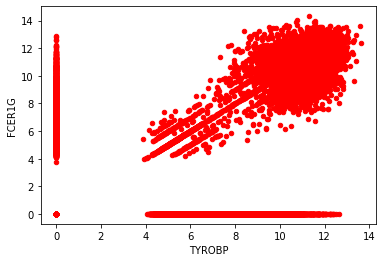

In [4]:
dir1 = "/booleanfs2/sahoo/Data/Colon/Cancer/GSE132465/"
cfile = dir1 + "Lee-2020-crc-csr-sc.h5ad"
import scanpy as sc
adata = sc.read(cfile)
mut.convertString(adata)
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata, base=2)
mut.scatterPlot(adata, 'TYROBP', 'FCER1G')
adata

In [5]:
macrophage_specific=pd.read_csv("merged.csv",sep=",")
macrophage_specific

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A2ML1-AS2,A3GALT2,A4GALT,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,bP-21264C1.2,bP-2171C21.3,bP-2189O9.3,hsa-mir-1253
0,0.394902,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.541128,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.214558,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.334168,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7097,0.000000,1.321023,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
7098,2.013474,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
7099,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
7100,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [6]:
barcodes=pd.read_csv("mac_cells.csv")
barcodes

,index
0,SMC02-T_TGATTTCCACGTCAGC
1,SMC03-T_TTTCCTCTCCAAGCCG
2,SMC04-T_TCGCGTTGTACCATCA
3,SMC05-T_GTCTCGTGTTACGGAG
4,SMC06-T_GTGCTTCTCACCAGGC
...,...
7097,SMC10-N_GCCAAATAGGATGCGT
7098,SMC10-N_GTATCTTGTAACGCGA
7099,SMC10-N_TCAGCTCGTAGCGTCC
7100,SMC10-N_TGCTACCGTCTCCATC


In [7]:
macrophage_specific.insert(0,"ArrayID",list(barcodes["index"]))
macrophage_specific

,ArrayID,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A2ML1-AS2,A3GALT2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,bP-21264C1.2,bP-2171C21.3,bP-2189O9.3,hsa-mir-1253
0,SMC02-T_TGATTTCCACGTCAGC,0.394902,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,SMC03-T_TTTCCTCTCCAAGCCG,0.000000,0.000000,0.0,0.541128,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.214558,0.0,0.000000,0.0,0.0,0.0,0.0
2,SMC04-T_TCGCGTTGTACCATCA,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.334168,0.0,0.0,0.0,0.0
3,SMC05-T_GTCTCGTGTTACGGAG,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
4,SMC06-T_GTGCTTCTCACCAGGC,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7097,SMC10-N_GCCAAATAGGATGCGT,0.000000,1.321023,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
7098,SMC10-N_GTATCTTGTAACGCGA,2.013474,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
7099,SMC10-N_TCAGCTCGTAGCGTCC,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
7100,SMC10-N_TGCTACCGTCTCCATC,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [8]:
import pandas as pd
meta=pd.read_csv("~/TAMs/GSE132465/GSE132465_GEO_processed_CRC_10X_cell_annotation.txt.gz",sep='\t')

res = dict(zip(list(meta["Index"]), list(meta["Sample"])))
GSM_sample=pd.read_csv("GSM_and_sample",sep="\t")
res2 = dict(zip(list(GSM_sample["Sample_Name"]), list(GSM_sample["GSM_ID"])))

sample=[]
for element in macrophage_specific["ArrayID"]:
    sample.append(res[element])

GSM_ids=[]
for element in sample:
    GSM_ids.append(res2[element])
    
macrophage_specific["ArrayID"]=GSM_ids
macrophage_specific

,ArrayID,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A2ML1-AS2,A3GALT2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,bP-21264C1.2,bP-2171C21.3,bP-2189O9.3,hsa-mir-1253
0,GSM3868426,0.394902,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,GSM3868427,0.000000,0.000000,0.0,0.541128,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.214558,0.0,0.000000,0.0,0.0,0.0,0.0
2,GSM3868428,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.334168,0.0,0.0,0.0,0.0
3,GSM3868429,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
4,GSM3868430,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7097,GSM3868457,0.000000,1.321023,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
7098,GSM3868457,2.013474,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
7099,GSM3868457,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
7100,GSM3868457,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [9]:
#Log Scaling for Normalization
normalized=macrophage_specific.select_dtypes(exclude=['object']) * 1.4427
normalized.insert(0,"ProbeId",list(macrophage_specific["ArrayID"]))
normalized

,ProbeId,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A2ML1-AS2,A3GALT2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,bP-21264C1.2,bP-2171C21.3,bP-2189O9.3,hsa-mir-1253
0,GSM3868426,0.569724,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,GSM3868427,0.000000,0.00000,0.0,0.780686,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.309544,0.0,0.000000,0.0,0.0,0.0,0.0
2,GSM3868428,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.482105,0.0,0.0,0.0,0.0
3,GSM3868429,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
4,GSM3868430,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7097,GSM3868457,0.000000,1.90584,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
7098,GSM3868457,2.904839,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
7099,GSM3868457,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
7100,GSM3868457,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [10]:
normalized2=normalized.set_index("ProbeId").T
normalized2.insert(0,"ProbeId",list(normalized.columns)[1:])
normalized2

ProbeId,ProbeId,GSM3868426,GSM3868427,GSM3868428,GSM3868429,GSM3868430,GSM3868431,GSM3868431,GSM3868433,GSM3868434,...,GSM3868457,GSM3868457,GSM3868457,GSM3868457,GSM3868457,GSM3868457,GSM3868457,GSM3868457,GSM3868457,GSM3868457
A1BG,A1BG,0.569724,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,2.904839,0.0,0.0,0.0
A1BG-AS1,A1BG-AS1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,1.703473,1.90584,0.000000,0.0,0.0,0.0
A1CF,A1CF,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.961699,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0
A2M,A2M,0.000000,0.780686,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,1.703473,0.00000,0.000000,0.0,0.0,0.0
A2M-AS1,A2M-AS1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZZZ3,ZZZ3,0.000000,0.000000,0.482105,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0
bP-21264C1.2,bP-21264C1.2,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0
bP-2171C21.3,bP-2171C21.3,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0
bP-2189O9.3,bP-2189O9.3,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0


In [11]:
tumor_vs_normal=[]

for element in GSM_sample["Sample_Name"]:
    tumor_vs_normal.append(str(element).split("-")[1])
res3 = dict(zip(list(GSM_sample["GSM_ID"]),tumor_vs_normal))

tumor_types=[]
for element in normalized["ProbeId"]:
    tumor_types.append(res3[element])

In [13]:
from anndata import AnnData
import scanpy as sc

adata = AnnData(normalized2.set_index('ProbeId').T)
adata.raw = adata
adata.raw.var['gene_symbols'] = list(normalized2["ProbeId"])
adata.raw.var['gene_ids'] = list(normalized2["ProbeId"])
adata.obs["tumor"]=tumor_types

computeSMART(adata)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


[4228, 4200, 2, 3123, 3289, 168, 14, 4252, 440, 51, 30, 14, 4207, 4200, 2, 7516, 25, 116, 78, 74, 122, 142, 4198, 2, 4250, 66, 2, 8, 144, 107, 14]
[66]
[48]
[-1]
[48]
[4228, 4200, 2, 3123, 3289, 168, 14, 4252, 440, 51, 30, 14, 4207, 4200, 2, 7516, 25, 116, 78, 74, 122, 142, 4198, 2, 4250, 66, 2, 8, 144, 107, 14]
[144, 168]
[137, 153]
[1, 2]
[113, 126]


AnnData object with n_obs × n_vars = 7102 × 33694
    obs: 'tumor', 'c13', 'c14_3', 'c14', 'c3'

Counter({'T': 569, 'N': 7}) Counter({'T': 6538, 'N': 564})
Counter({'T': 2468, 'N': 374}) Counter({'T': 6538, 'N': 564})


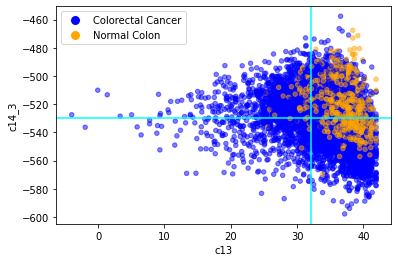

In [24]:
plotdf = sc.get.obs_df(adata, keys=["c13", "c14_3", 'tumor'])
ahash = {'T':'blue','N':'orange'}
#ahash = {'Tumor':acolor[0], 'Normal':acolor[1]}
 

thr1 = hu.getThrData(plotdf['c13'])
thr2 = hu.getThrData(plotdf['c14_3'])

c1 = (plotdf['c13'] <= thr1[0])
c2 = (plotdf['c14_3'] <= thr2[0])

c3 = (plotdf['c13'] > thr1[0])
c4 = (plotdf['c14_3'] > thr2[0])

plotdf['color'] = [ahash[k] for k in plotdf['tumor']]
ax=plotdf.plot.scatter("c13", "c14_3", c="color", alpha=0.5, rasterized=True)
ax.axhline(y=thr2[0], color='cyan')
ax.axvline(x=thr1[0], color='cyan')

# Create custom legend handles
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Colorectal Cancer'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Normal Colon')
]

# Add custom legend to the plot
ax.legend(handles=handles)


print(Counter(plotdf[c1 & c2]['tumor']), Counter(plotdf['tumor']))
print(Counter(plotdf[c3 & c4]['tumor']), Counter(plotdf['tumor']))

In [17]:
stats,pval=proportions_ztest(7, 564, 569/6538)
print(pval)

1.1570973262185148e-57


In [18]:
stats,pval=proportions_ztest(374, 564, 2468/6538)
print(pval)

1.0325240487643097e-46
